## Baseline AES Attacks VGG19

Using Transfer Learning with VGG19

In [1]:
# import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
random_num = 71

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from keras.layers import Input, Conv1D, AveragePooling1D, Flatten, Dense
from keras import Model
from keras.optimizers import RMSprop
from keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(keras.__version__)
print(tf.__version__)

2.10.0
2.10.0


In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
# read files
traces_df = pd.read_csv('./data/MS1_traces.csv')
labels_df = pd.read_csv('./data/MS1_labels.csv')

In [5]:
labels_df.describe()

,Pinata/MS1/Profiling/Labels
count,150000.000000
mean,127.604440
std,73.899126
min,0.000000
25%,64.000000
50%,127.000000
75%,192.000000
max,255.000000


In [6]:
traces_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,29.681895,29.258129,29.160057,29.572917,30.177074,30.752652,31.527438,32.473018,33.563043,34.545233,...,-14.550743,-16.351476,-18.056034,-19.652571,-21.115143,-22.454962,-23.677953,-24.785945,-25.791785,-26.707552
std,2.704074,2.710826,2.676505,2.653991,2.646377,2.645058,2.635097,2.607498,2.587267,2.582451,...,2.356063,2.449597,2.535514,2.624639,2.715132,2.803579,2.893225,2.979074,3.061829,3.146384
min,-1.500000,-1.300000,-1.300000,-1.300000,-1.400000,-1.500000,-1.500000,-1.500000,-1.700000,-1.800000,...,-25.000000,-27.400000,-28.800000,-29.700000,-31.100000,-32.900000,-34.000000,-35.300000,-36.300000,-36.600000
25%,27.900000,27.500000,27.400000,27.900000,28.500000,29.000000,29.900000,30.900000,32.000000,33.000000,...,-16.200000,-18.100000,-19.800000,-21.500000,-23.000000,-24.400000,-25.700000,-26.900000,-28.000000,-28.900000
50%,29.600000,29.200000,29.100000,29.500000,30.100000,30.800000,31.600000,32.500000,33.600000,34.600000,...,-14.600000,-16.400000,-18.200000,-19.700000,-21.200000,-22.600000,-23.800000,-24.900000,-25.900000,-26.800000
75%,31.500000,31.000000,30.900000,31.300000,31.900000,32.500000,33.300000,34.200000,35.200000,36.100000,...,-13.000000,-14.800000,-16.500000,-18.000000,-19.400000,-20.700000,-21.900000,-23.000000,-23.900000,-24.800000
max,42.300000,42.300000,41.900000,41.900000,42.300000,42.800000,42.900000,43.600000,45.200000,46.000000,...,5.700000,4.700000,3.700000,2.500000,2.300000,2.300000,2.300000,2.300000,2.300000,2.700000


In [7]:
traces_df

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,29.4,28.9,28.8,29.7,30.3,31.1,32.7,34.4,35.7,36.6,...,-15.9,-17.5,-19.0,-20.9,-22.3,-23.5,-25.1,-26.5,-27.5,-28.4
1,27.8,27.1,26.5,27.1,27.8,27.7,28.4,29.9,30.7,31.0,...,-15.1,-16.7,-18.3,-20.0,-21.6,-23.3,-24.4,-25.2,-26.6,-27.7
2,29.8,28.8,28.5,29.2,29.9,30.7,31.4,32.4,33.6,34.7,...,-15.1,-17.3,-18.9,-20.6,-22.4,-24.0,-25.1,-26.0,-26.9,-27.8
3,27.8,27.6,27.9,28.4,29.5,30.6,31.5,32.5,33.7,35.1,...,-15.3,-17.3,-18.6,-20.1,-21.8,-23.4,-24.7,-25.9,-27.0,-27.9
4,29.0,28.7,28.3,28.8,29.2,30.3,31.8,32.9,34.1,35.4,...,-13.4,-15.5,-17.7,-19.1,-20.6,-22.4,-23.7,-24.6,-25.8,-26.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,28.2,28.4,29.0,29.4,30.5,31.7,32.4,33.4,34.7,35.3,...,-14.4,-16.3,-18.2,-19.9,-21.2,-22.3,-23.9,-24.6,-25.5,-26.3
149996,27.7,26.5,26.2,26.7,27.3,27.5,28.1,29.5,30.5,31.2,...,-14.1,-16.0,-17.3,-18.4,-19.3,-20.1,-21.3,-22.7,-23.6,-23.6
149997,28.2,28.3,28.3,28.4,28.6,28.6,29.5,30.6,31.4,32.4,...,-11.5,-12.7,-14.1,-15.8,-17.4,-18.4,-19.3,-20.5,-21.4,-22.3
149998,25.8,25.7,25.9,26.6,27.8,28.5,29.8,31.0,32.1,32.9,...,-13.2,-14.6,-16.1,-17.7,-19.3,-20.3,-21.6,-22.9,-23.4,-24.6


In [8]:
# are the different labels balanced?
print(labels_df.columns)
print(labels_df['Pinata/MS1/Profiling/Labels'].value_counts())

value_counts = labels_df['Pinata/MS1/Profiling/Labels'].value_counts()

# Create a new DataFrame from the value counts
value_counts_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values})

Index(['Pinata/MS1/Profiling/Labels'], dtype='object')
Pinata/MS1/Profiling/Labels
215    651
79     642
247    642
153    642
46     640
      ... 
6      542
62     542
184    534
91     518
140    507
Name: count, Length: 256, dtype: int64


In [9]:
value_counts_df.columns

Index(['Value', 'Count'], dtype='object')

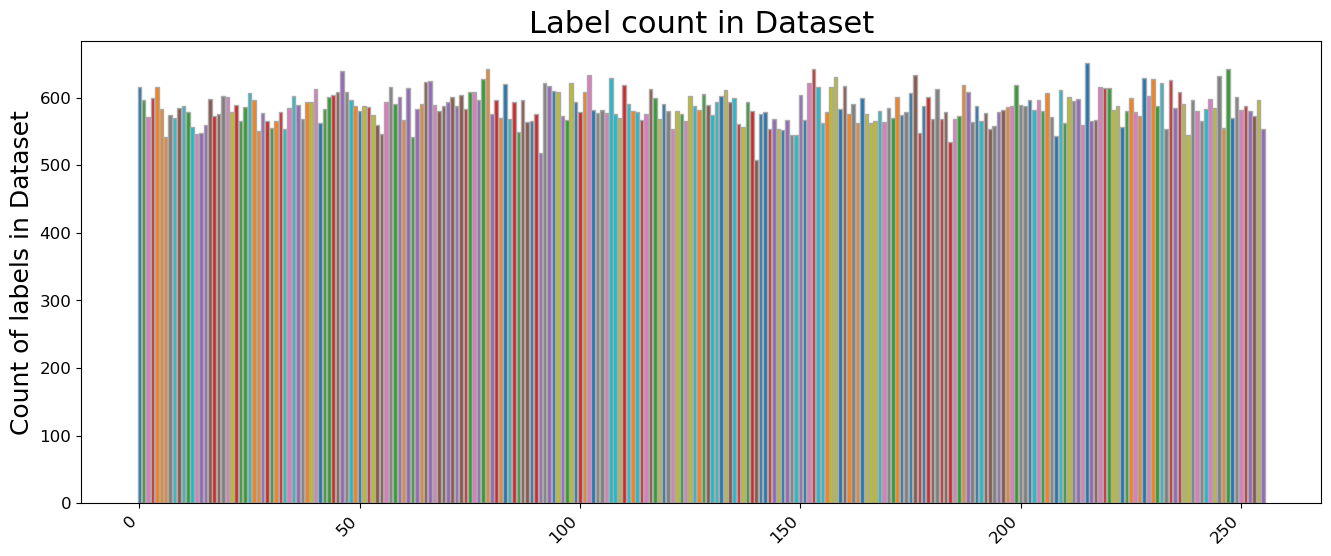

In [10]:
# Let's visualize balancing of dataset
fig, ax = plt.subplots(figsize=(16, 6))
#sns.set(style = 'white')
name = "tab10"
cmap = plt.get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

plt.title('Label count in Dataset', size=22)
ax.bar(value_counts_df['Value'], value_counts_df['Count'], color=colors, edgecolor='darkgrey')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Count of labels in Dataset', size=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.show()

In [11]:
# transform dataframe to numpy arrays for convenience (DL will work much faster)
traces = traces_df.values
labels = labels_df.values
dummy_y = np_utils.to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(traces, dummy_y, test_size=0.2, random_state=random_num)
print('train',X_train.shape, 'test', X_test.shape)

train (120000, 1500) test (30000, 1500)


In [12]:

dummy_y = np_utils.to_categorical(labels)
dummy_y.shape

(150000, 256)

In [13]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 10,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [14]:
# setting up the convolutional network

### CNN Best model
def cnn_net(classes=256,input_dim=1500):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(lr=0.00001)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [15]:
keras.backend.clear_session()

CNN = cnn_net()

CNN.load_weights('./data/CNN_vgg16.5')
CNN.summary()

Model: "cnn_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1500, 1)]         0         
                                                                 
 block1_conv1 (Conv1D)       (None, 1500, 64)          768       
                                                                 
 block1_pool (AveragePooling  (None, 750, 64)          0         
 1D)                                                             
                                                                 
 block2_conv1 (Conv1D)       (None, 750, 128)          90240     
                                                                 
 block2_pool (AveragePooling  (None, 375, 128)         0         
 1D)                                                             
                                                                 
 block3_conv1 (Conv1D)       (None, 375, 256)          360

In [ ]:
CNN.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
3750/3750 [==============================] - 7745s 2s/step - loss: 4.2643 - accuracy: 0.0325 - val_loss: 4.4677 - val_accuracy: 0.0244
Epoch 2/10
1313/3750 [=========>....................] - ETA: 1:20:31 - loss: 4.2297 - accuracy: 0.0343

In [ ]:
CNN.save_weights('./data/CNN_vgg16.5')

In [ ]:
stop

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

In [ ]:
score = model_pretrained.evaluate(ds_test, steps = len(test_df), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Result Performance Evaluation</a>  

In [ ]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

In [ ]:
#EOF